In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import sys

import torch

rootDir = Path(os.path.abspath(__name__)).parent.parent
sys.path.append(str(rootDir))

from commsimcnn.util import *
from commsimcnn.models import TinyVGG
from commsimcnn.simdataloader import SimDataLoader
from commsimcnn.cnn import CNNModel

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

print(torch.__version__)
print(torchvision.__version__)

2.9.1+cu126
0.24.1+cu126


In [14]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to
    train=True, # Do we want the training dataset
    download=True, # Do we want to download
    transform=ToTensor(), # How do we want to transform the data
    target_transform=None # how do we want to transform the labels/targets
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data", # where to download data to
    train=False, # Do we want the training dataset
    download=True, # Do we want to download
    transform=ToTensor(), # How do we want to transform the data
)

In [16]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [5]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

# For test data, generally good to not shuffle (easier for evaluation)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x71cff37a2570>,
 <torch.utils.data.dataloader.DataLoader at 0x71cffee12300>)

In [6]:
mod0 = TinyVGG(input_shape=torch.Size([32, 1, 28, 28]),
               output_shape=10,
               in_channels=1).to(device)         

Output Height: 4 | Output Width: 4


In [7]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
  """ Performs a training step with a model trying to learn on data_loader"""
  train_loss, train_acc = 0, 0
  model.to(device)

  # Put model into training mode
  model.train()

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):

    #Put data on target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  # Divide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  print(f"Train loss: {train_loss:.5f}\n")

In [8]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
  """Performs a testing loop step on model going over data_loader."""

  test_loss, test_acc = 0, 0
  model.to(device)

  # Put the model in eval mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:

      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculate loss (accumulatively)
      test_loss += loss_fn(test_pred, y)

    # Calculate the test loss average per batch
    test_loss /= len(data_loader)

  # Print out what's happening
  print(f"Test loss: {test_loss:.5f}\n")

In [9]:
# Loss function/eval metrics/optimizer
from torch import nn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mod0.parameters(),
                            lr=0.1)

In [10]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""

  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [11]:
from tqdm.auto import tqdm

torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n----------")
  train_step(model=mod0,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             device=device)
  test_step(model=mod0,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             device=device)

train_time_end = timer()
total_train_time = print_train_time(start=train_time_start,
                                            end=train_time_end)

/home/trevor/dev/CommSimCNN/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
Train loss: 0.73749



 33%|███▎      | 1/3 [00:02<00:05,  2.56s/it]

Test loss: 0.47832

Epoch: 1
----------
Train loss: 0.42598



 67%|██████▋   | 2/3 [00:04<00:02,  2.44s/it]

Test loss: 0.41000

Epoch: 2
----------
Train loss: 0.38092



100%|██████████| 3/3 [00:07<00:00,  2.43s/it]

Test loss: 0.37753

Train time on None: 7.302 seconds


In [12]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = SimDataLoader('/home/trevor/Documents/research/CommSim/data/POD_sim_data_normal/train')
test_data = SimDataLoader('/home/trevor/Documents/research/CommSim/data/POD_sim_data_normal/test')

In [14]:
train_data[0]

(tensor([[[0.0080, 0.0106, 0.0000, 0.1671, 0.0716, 0.0133, 0.0000, 0.0000,
           0.0000, 0.0027, 0.0000, 0.0398, 0.0186, 0.0000, 0.0000, 0.0000,
           0.0504, 0.0610, 0.0000, 0.0000, 0.0318, 0.1618, 0.0239, 0.0477,
           0.0345, 0.0345, 0.0398, 0.0212, 0.0053, 0.1565],
          [0.0371, 0.0265, 0.0000, 0.1247, 0.0451, 0.0477, 0.0027, 0.0292,
           0.0053, 0.1088, 0.0106, 0.0610, 0.0000, 0.0000, 0.0743, 0.0000,
           0.0159, 0.0027, 0.0000, 0.0000, 0.0000, 0.0477, 0.0053, 0.1061,
           0.0186, 0.0822, 0.0769, 0.0292, 0.0027, 0.0398],
          [0.0424, 0.0557, 0.0000, 0.0902, 0.0292, 0.1141, 0.0000, 0.0027,
           0.0000, 0.0159, 0.0053, 0.0318, 0.0371, 0.0053, 0.0000, 0.0000,
           0.0265, 0.0159, 0.0000, 0.0000, 0.0053, 0.0849, 0.0080, 0.0345,
           0.1220, 0.0371, 0.0292, 0.0212, 0.0000, 0.1857],
          [0.0265, 0.0610, 0.0053, 0.1114, 0.0637, 0.0080, 0.0398, 0.0796,
           0.0000, 0.1088, 0.0000, 0.0133, 0.0000, 0.0000, 0.0796, 0.0

In [72]:
from typing import List
import random
import matplotlib.pyplot as plt

def plot_random_sims(dataset: torch.utils.data.Dataset,
                     classes: List[str],
                     n: int = 9,
                     seed: int = None):
    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16,8))

    for i, targ_sample in enumerate(random_samples_idx):
        targ_sim, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        targ_sim_adjust = targ_sim.permute(1, 2, 0)

        plt.subplot(1, n, i+1)
        plt.imshow(targ_sim_adjust, cmap='grey')
        plt.axis("off")
        if classes:
            title = f"Class: {classes[targ_label]}"
        plt.title(title)

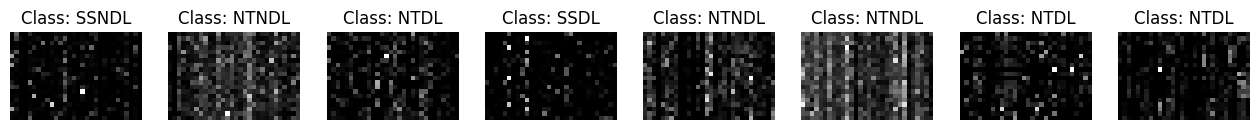

In [80]:
plot_random_sims(dataset=train_data,
                 n=8,
                 classes=train_data.classes)

In [60]:
import pandas as pd
import numpy as np

test = pd.read_csv(train_data.paths[])
row_sums = test.sum(axis=1)
test_normalized = test.div(row_sums, axis=0)
test_np = torch.Tensor(test_normalized.to_numpy(dtype=float)).unsqueeze(dim=0)

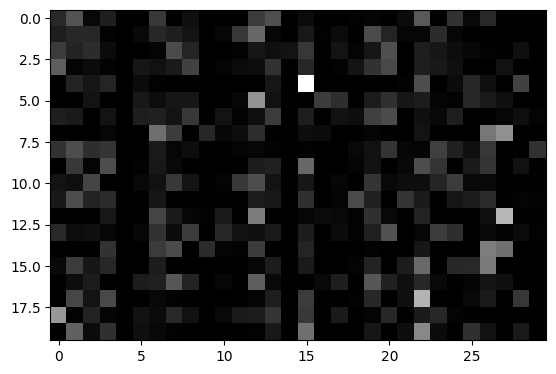

In [61]:
plt.imshow(test_np.permute(1, 2, 0), cmap='grey')

In [24]:
sim_path = self.paths[index]
data = pd.read_csv(sim_path)
data = data.to_numpy(dtype=float)
row_sums = np.sum(data, axis=1)[:, None]
data = data / row_sums
data = torch.ten

tensor([[[0.0080, 0.0106, 0.0000, 0.1671, 0.0716, 0.0133, 0.0000, 0.0000,
          0.0000, 0.0027, 0.0000, 0.0398, 0.0186, 0.0000, 0.0000, 0.0000,
          0.0504, 0.0610, 0.0000, 0.0000, 0.0318, 0.1618, 0.0239, 0.0477,
          0.0345, 0.0345, 0.0398, 0.0212, 0.0053, 0.1565],
         [0.0371, 0.0265, 0.0000, 0.1247, 0.0451, 0.0477, 0.0027, 0.0292,
          0.0053, 0.1088, 0.0106, 0.0610, 0.0000, 0.0000, 0.0743, 0.0000,
          0.0159, 0.0027, 0.0000, 0.0000, 0.0000, 0.0477, 0.0053, 0.1061,
          0.0186, 0.0822, 0.0769, 0.0292, 0.0027, 0.0398],
         [0.0424, 0.0557, 0.0000, 0.0902, 0.0292, 0.1141, 0.0000, 0.0027,
          0.0000, 0.0159, 0.0053, 0.0318, 0.0371, 0.0053, 0.0000, 0.0000,
          0.0265, 0.0159, 0.0000, 0.0000, 0.0053, 0.0849, 0.0080, 0.0345,
          0.1220, 0.0371, 0.0292, 0.0212, 0.0000, 0.1857],
         [0.0265, 0.0610, 0.0053, 0.1114, 0.0637, 0.0080, 0.0398, 0.0796,
          0.0000, 0.1088, 0.0000, 0.0133, 0.0000, 0.0000, 0.0796, 0.0000,
         

In [15]:
train_data = SimDataLoader('/home/trevor/dev/CommSimCNN/tests/test_data/train')


In [17]:
train_data[0]

(tensor([[[0.0854, 0.0534, 0.0925, 0.0961, 0.0498, 0.1246, 0.1246, 0.1601,
           0.0498, 0.1637],
          [0.1894, 0.0631, 0.0620, 0.0379, 0.1607, 0.0299, 0.0700, 0.1630,
           0.1068, 0.1171],
          [0.0489, 0.0814, 0.0847, 0.0879, 0.1075, 0.1564, 0.0391, 0.1026,
           0.1303, 0.1612],
          [0.1065, 0.0447, 0.2096, 0.0687, 0.1890, 0.0172, 0.0619, 0.1271,
           0.0653, 0.1100],
          [0.0310, 0.0487, 0.0929, 0.1460, 0.1903, 0.0885, 0.0619, 0.1770,
           0.1062, 0.0575],
          [0.1101, 0.0780, 0.1606, 0.0963, 0.1743, 0.0550, 0.0963, 0.0917,
           0.0826, 0.0550],
          [0.0991, 0.0613, 0.1226, 0.0472, 0.2406, 0.0802, 0.0660, 0.1038,
           0.1226, 0.0566],
          [0.0550, 0.0258, 0.2526, 0.0344, 0.2010, 0.0344, 0.0378, 0.0636,
           0.0893, 0.2062],
          [0.0586, 0.0360, 0.1802, 0.0766, 0.1847, 0.0383, 0.0676, 0.1014,
           0.1351, 0.1216],
          [0.1573, 0.0275, 0.0824, 0.1557, 0.1878, 0.0687, 0.0076, 0.1160

In [2]:
from torch import nn

test = CNNModel(
    train_data_path='/home/trevor/Documents/research/CommSim/data/POD_sim_data_normal/train',
    test_data_path='/home/trevor/Documents/research/CommSim/data/POD_sim_data_normal/test',
    loss_fn=nn.CrossEntropyLoss(),
    optimizer='adam'
)

In [4]:
test.train_step()

In [9]:
test.train_loss

[0.9811480664014817]

In [ ]:
test = CNNModel(
        train_data_path='/home/trevor/dev/CommSimCNN/tests/test_data/train',
        test_data_path='/home/trevor/dev/CommSimCNN/tests/test_data/test',
        loss_fn=torch.nn.CrossEntropyLoss(),
        optimizer='Adam'
    )

/home/trevor/dev/CommSimCNN/.venv/lib/python3.12/site-packages/torch/nn/init.py:566: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/trevor/miniconda3/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/home/trevor/miniconda3/lib/python3.12/multiprocessing/connection.py", line 178, in close
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/trevor/miniconda3/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    self._close()
  File "/home/trevor/miniconda3/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/trevor/miniconda3/lib/python3.12/threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "/home/trevor/miniconda3/lib/python3.12/threading.py", line 1010, in run
    reader_close()
  File "/home/trevor/miniconda3/lib/python3.12/multipr

In [38]:
test_data_train = SimDataLoader('/home/trevor/dev/CommSimCNN/tests/test_data/train')
test_data_test = SimDataLoader('/home/trevor/dev/CommSimCNN/tests/test_data/test')

train_dataloader = torch.utils.data.DataLoader(
    dataset=test_data_train,
    batch_size=32,
    num_workers = os.cpu_count() -2,
    shuffle=True
)

In [39]:
for i in range(len(test_data_train)):
    print(test_data_train.paths[i])
    print(test_data_train[i][0].shape)

/home/trevor/dev/CommSimCNN/tests/test_data/train/SSNDL/sim54.csv.gz
torch.Size([1, 15, 10])
/home/trevor/dev/CommSimCNN/tests/test_data/train/SSNDL/sim58.csv.gz
torch.Size([1, 15, 10])
/home/trevor/dev/CommSimCNN/tests/test_data/train/SSNDL/sim44.csv.gz
torch.Size([1, 15, 10])
/home/trevor/dev/CommSimCNN/tests/test_data/train/SSNDL/sim51.csv.gz
torch.Size([1, 15, 10])
/home/trevor/dev/CommSimCNN/tests/test_data/train/SSNDL/sim31.csv.gz
torch.Size([1, 15, 10])
/home/trevor/dev/CommSimCNN/tests/test_data/train/SSNDL/sim23.csv.gz
torch.Size([1, 15, 10])
/home/trevor/dev/CommSimCNN/tests/test_data/train/SSNDL/sim12.csv.gz
torch.Size([1, 15, 10])
/home/trevor/dev/CommSimCNN/tests/test_data/train/SSNDL/sim28.csv.gz
torch.Size([1, 15, 10])
/home/trevor/dev/CommSimCNN/tests/test_data/train/SSNDL/sim38.csv.gz
torch.Size([1, 15, 10])
/home/trevor/dev/CommSimCNN/tests/test_data/train/SSNDL/sim72.csv.gz
torch.Size([1, 15, 10])
/home/trevor/dev/CommSimCNN/tests/test_data/train/SSNDL/sim49.csv.gz
t

In [22]:
input_shape = next(iter(train_dataloader))[0].shape

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/trevor/dev/CommSimCNN/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/trevor/dev/CommSimCNN/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/trevor/dev/CommSimCNN/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/trevor/dev/CommSimCNN/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 212, in collate
    collate(samples, collate_fn_map=collate_fn_map)
  File "/home/trevor/dev/CommSimCNN/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/trevor/dev/CommSimCNN/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 272, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: stack expects each tensor to be equal size, but got [1, 15, 10] at entry 0 and [1, 150, 1] at entry 1
